### Multi-Armed Bandit

In my previous post, I had introduced Gaussian Process. In this post, I am going to focus on the task of active learning - where we query the user/oracle to label samples. The main motivation behind active learning is the expensive cost of labelling in machine learning tasks. 

#### Mining Gold!

In this post, we will assume a mining application - mining for gold! We will simplify the problem by stating that we need to search for gold in a 1d search space. At each prospective location, we have to drill a hole and use some expensive sensors to find out the amount of gold in that location. Given the expensive nature of this drilling, we would not be able to drill at all locations. Thus, the active learning problem comes into picture.

#### Problem: Determine the location with maximum gold


We would be starting with some very naive assumption that the gold distribution of nearby points in similar (smoothness). GPs fit very well in this active learning problem as they give us not only the predictions but also the uncertainty. One popular active learning strategy is to choose the next location to drill (or query in more general sense) as the location about which we are most uncertain about (highest variance).

Here is a representative animation showing the process of drilling at new locations and reducing the undertainty. We will build this from ground up in this post.



#### Some imports

In [19]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.special import ndtr
from scipy.stats import norm

warnings.filterwarnings('ignore')
%matplotlib inline

#### Prettyfing Matplotlib plots

In [20]:
SPINE_COLOR = 'gray'

def format_axes(ax):
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

#### Creating ground truth data

In [21]:
def f(x):
    """The function to predict."""
    return 2*((x-3)*np.sin((x-3))) + 2 + 0.5*x

Let us now try to see how our groundtruth data looks like.

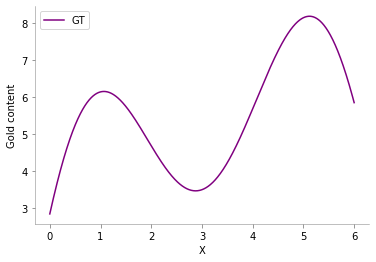

In [22]:
x = np.atleast_2d(np.linspace(0, 6, 1000)).T
plt.plot(x, f(x), color='purple', label='GT')
plt.xlabel("X")
plt.ylabel("Gold content")
plt.legend()
format_axes(plt.gca())

#### Plotting our prior model

Our prior model doesn't know much and assumes a smooth relationship between points via an RBF kernel.

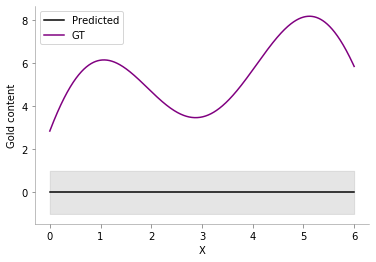

In [23]:
gp = GaussianProcessRegressor()
y_pred, sigma = gp.predict(x, return_std=True)
plt.plot(x, y_pred, 'k', label='Predicted', lw=1.5)
plt.plot(x, f(x), 'purple', label='GT', lw=1.5)
plt.xlabel("X")
plt.ylabel("Gold content")
plt.fill_between(x.flatten(), y_pred+sigma, y_pred-sigma, color='gray', alpha=0.2)
plt.legend()
format_axes(plt.gca())

In [24]:
def rargmax(b):
    """Randomly tie breaking argmax"""
    return np.random.choice(np.flatnonzero(b == b.max()))

Looks like our prediction isn't very useful at this point. But, we haven't seen any data yet, right! We can also see the same variance at all the data points. 

In [25]:
class ACQ:
    def acq_fn(self, *args, **kwargs):
        raise NotImplemented
    
    def __str__(self):
        return self.__class__.__name__
    
    def __call__(self, *args, **kwargs):
        return self.acq_fn(*args, **kwargs)

In [26]:
class ACQ1(ACQ):
    def acq_fn(self, gp_reg, x, lam = 0.4, **kwrags):
        """
        gp_reg: sklearn.GPRegresssor
        lam: float, where the objective is: \mu(x) + \lambda \sigma(x)
        """
        y_pred, sigma = gp_reg.predict(x, return_std=True)

        return y_pred + lam*sigma

### Adding a point to the train set

Let us now add a point to the train set and see how our posterior changes after we fit the model to the new data. I am going to add `(x = 0.5, y = f(0.5))` into the train set now.

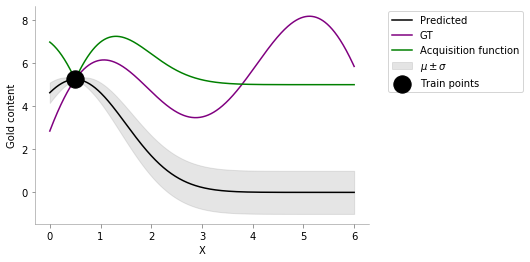

In [27]:
acq_obj = ACQ1()

train_X = np.atleast_2d([0.5]).T
train_y = f(train_X).ravel()
gp.fit(train_X, train_y)
y_pred, sigma = gp.predict(x, return_std=True)
plt.plot(x, y_pred, 'k', label='Predicted')
plt.plot(x, f(x), 'purple', label='GT')
plt.xlabel("X")
plt.ylabel("Gold content")
plt.fill_between(x.flatten(), y_pred+sigma, y_pred-sigma, color='gray', alpha=0.2, label=r'$\mu \pm \sigma$')
plt.scatter(train_X, train_y, color='red', s=200, zorder=10, label='Train points')
plt.plot(x, acq_obj(gp, x, 5), label='Acquisition function', color='green')
format_axes(plt.gca())
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

Nice, we can see now that the posterior has changed. We are very certain about the points in the vicinity of x = 0.5, but, very uncertain far away from it. So, we now come to the key idea.

#### Active learning procedure

1. Choose the point having highest uncertainty
2. Add the point to train set
3. Train on the new train set
4. Go to 1 till convergence or budget elapsed

In [28]:
def plot_acquisition(
        train_X, train_y,
        acq_class, acq_params={},
        ylim0=None, xlim0=None,
        ylim1=None, xlim1=None,
        y1scale='linear', it = 10,
        seed = 2
    ):
    """acq_params would contain the parameters for our acq_fn"""
    np.random.seed(seed)
    # for storing the max till it iters
    max_till_now = []
    
    # Stopping criteria is 10 iterations
    for i in range(it):
        fig, ax = plt.subplots(nrows=2, sharex=True)
        ax[1].set_yscale(y1scale)
        
        # limits
        ax[0].set_ylim(ylim0) if ylim0 is not None else ax[0].set_ylim(min(f(x)), max(f(x)))
        ax[0].set_xlim(xlim0) if xlim0 is not None else ax[0].set_xlim(min(x), max(x))
        ax[1].set_ylim(ylim1) if ylim1 is not None else None
        ax[1].set_xlim(xlim1) if xlim1 is not None else ax[1].set_xlim(min(x), max(x))
        
        
        # fitting
        gp.fit(train_X, train_y.flatten())
        
        # plot Acquisition
        acq_obj = acq_class()
        acquisition = acq_obj(gp, x, t=i+1, **acq_params, train_y=train_y)
        ax[1].plot(x, acquisition, 
                   label='Acquisition function', color='green')
        
        # predict on current pool set
        y_pred, sigma = gp.predict(x, return_std=True)
        ax[0].plot(x, y_pred, 'k', label='Predicted')
        ax[0].plot(x, f(x), 'purple', label='GT')
        ax[0].set_xlabel("X")
        ax[0].set_ylabel("Gold content")
        ax[0].fill_between(x.flatten(), y_pred+sigma,
                           y_pred-sigma, color='gray',
                           alpha=0.2, label=r'$\mu \pm \sigma$')
        ax[0].scatter(train_X, train_y, color='black', s=100, zorder=10, label='Train points')
        ax[0].legend(bbox_to_anchor=(1.04,1), loc="upper left")
        ax[1].set_ylabel(str(acq_obj))
        ax[0].set_title(f"Iteration: {i}")
        
        # Choose the next point with highest sigma
        max_mu = np.max(train_y).flatten()[0]
        next_ix = rargmax(acquisition)
        next_x = x[next_ix]

        # Add new point with highest uncertainty to the pool set
        train_X = np.vstack([train_X, [x[next_ix]]])
        train_y = f(train_X)

        # Add new point with highest uncertainty to the pool set
        ax[1].scatter(x[next_ix], acquisition[next_ix], marker='X',s=50,
                      c='orange', zorder=10, label='maxima (tie randomly broken)')
        ax[0].scatter(x[next_ix], f(x[next_ix]), color='red',
                      s=200, zorder=-10, label='New Added points')
        ax[0].legend(bbox_to_anchor=(1.1,1), loc="upper left")
        ax[1].legend(bbox_to_anchor=(1.1,0.5), loc="upper left")
        train_X = np.vstack([train_X, [x[next_ix]]])
        train_y = f(train_X)
        max_till_now.append(np.argmax(train_y))
        format_axes(ax[0])
        format_axes(ax[1])

        acq_params_str = '-'.join(list(map(str, acq_params.values())))
        dirName = './'+str(acq_obj)+'/'+acq_params_str
        os.makedirs(dirName, exist_ok=True)
        plt.savefig(f"{dirName}/{i}.png", bbox_inches="tight")
        plt.close()
    return dirName, max_till_now

In [29]:
train_X = np.atleast_2d([0.5]).T
train_y = f(train_X).ravel()
acq_params = {'lam': 1}

dirName, mtn_acq1 = plot_acquisition(
    train_X, train_y,
    ACQ1, acq_params,
    ylim1=(1, 10)
)

# gify
!convert -delay 40 -loop 0 {dirName}/*.png mab-gp-1.gif

Let us now write a simple function to create the animation shown at the top of the post!

![](mab-gp-1.gif)

In [30]:
acq_params = {'lam': 5}

dirName, mtn_acq5 = plot_acquisition(
    train_X, train_y,
    ACQ1, acq_params,
    ylim1=(1, 10)
)

In [31]:
!convert -delay 40 -loop 0 {dirName}/*.png mab-gp-5.gif

![](mab-gp-5.gif)

In [33]:
acq_params = {'lam': 10}

dirName, mtn_acq10 = plot_acquisition(
    train_X, train_y,
    ACQ1, acq_params,
    ylim1=(1, 14)
)

In [34]:
!convert -delay 40 -loop 0 {dirName}/*.png mab-gp-10.gif

![](mab-gp-10.gif)

### Probability of improvement (PI)

Let us look into our next method for the MAB maximisation problem. As before, we want to balance or trade-off between exploration and exploitation. The idea behind the algorithm is fairly simple - choose the next point as the one which has the highest probability of improvement over the current max ($\mu^+$).


Let's understand this concept via two cases:

1. We have two points of similar means (of function values (gold in our case)). We now want to choose one of these to obtain the labels or values. We will choose the one with higher variance. This basically says that given same exploitability, we choose the one with higher exploration value.
2. We have two points having same variance. We would now choose the point with the higher mean. This basically says that given same explorability, we will choose the one with higher exploitation value.


1. Let $\mu^+$ be the current highest value of the function
2. Let $\epsilon$ be close to zero
3. Choose $x^* = arg\,max(P(f(x)) > (\mu^+ +\epsilon))$

This can be given as: $x^* = _{arg\,max_{x}} \Phi(\frac{\mu(x) - \mu^+ - \epsilon}{\sigma(x)})$ where
$\Phi(.)$ indicates the CDF.

In [35]:
# Code is heavily borrowed from: https://modal-python.readthedocs.io/en/latest/_modules/modAL/acquisition.html#max_PI
class PI(ACQ):
    def acq_fn(
        self, gp_reg, x, mu=5., eps=0.01, **kwargs):
        """
        gp_reg: sklearn.GPRegresssor
        """
        y_pred, sigma = gp_reg.predict(x, return_std=True)
        cdf = ndtr((y_pred - mu - eps)/sigma)
        return cdf

Text(0.5, 0, 'X')

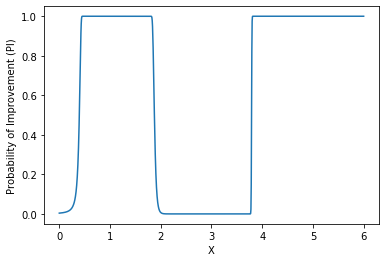

In [36]:
p = PI()
plt.plot(x, p(gp, x))
plt.ylabel("Probability of Improvement (PI)")
plt.xlabel("X")

In [37]:
dirName, mtn_pi = plot_acquisition(
    train_X, train_y,
    PI, ylim1=((0, 10**15)),
    y1scale='log'
)

In [38]:
!convert -delay 40 -loop 0 {dirName}/*.png mab-gp-pi.gif

![](mab-gp-pi.gif)

### Expected Improvement

Probability of improvement only looked at `how likely` is an improvement, but, shouldn't we be looking into `how much` we can improve. The next criterion called Expected Improvement (EI) looks into both :)

\begin{equation}
    EI(x)=
    \begin{cases}
      (\mu(x) - \mu^+ - \epsilon)\Phi(Z) + \sigma(x)\phi(Z), & \text{if}\ \sigma(x) > 0 \\
      0 & \text{if}\ \sigma(x) = 0 
    \end{cases}
  \end{equation}
 $$Z= \frac{\mu(x) - \mu^+ - \epsilon}{\sigma(x)}$$
 where $\Phi(.)$ indicates CDF and $\phi(.)$ indicates pdf

In [39]:
class EI(ACQ):
    def acq_fn(self, gp_reg, x, mu=5., eps=0.01, **kwargs):
        """
        gp_reg: sklearn.GPRegresssor
        """
        #ei = np.zeros_like(x)
        y_pred, sigma = gp_reg.predict(x, return_std=True)
        #ei[sigma<1e-10] = 0
        z = (y_pred - mu - eps)/sigma
        return (y_pred - mu - eps)*ndtr(z) + sigma*norm.pdf(z)

In [41]:
dirName, mtn_ei = plot_acquisition(
    train_X, train_y,
    EI, ylim1=((0, 4)),
)

# gify!
!convert -delay 40 -loop 0 {dirName}/*.png mab-gp-ei.gif

![](mab-gp-ei.gif)

### Expected Improvement + Probability of Improvement

In [42]:
class EI_PI(ACQ):
    def acq_fn(self, gp_reg, x, mu=5., eps=0.01, lam=3, **kwargs):
        """
        gp_reg: sklearn.GPRegresssor
        """
        y_pred, sigma = gp_reg.predict(x, return_std=True)
        
        # ei
        z = (y_pred - mu - eps)/sigma
        out = (y_pred - mu - eps)*ndtr(z) + sigma*norm.pdf(z)
        # pi
        cdf = ndtr((y_pred - mu - eps)/sigma)
        
        return cdf * lam + out

In [43]:
dirName, mtn_ei_pi = plot_acquisition(
    train_X, train_y,
    EI_PI, ylim1=((0, 10)),
)

# gify!
!convert -delay 40 -loop 0 {dirName}/*.png mab-gp-ei_pi.gif

![](mab-gp-ei_pi.gif)

### GP-UCB



In [44]:
class GP_UCB(ACQ):
    def acq_fn(self, gp_reg, x, t, mu=5., 
               eps=0.01, v = 1., delta=1., **kwargs):
        """
        gp_reg: sklearn.GPRegresssor
        t: Iteration number (1, ..)
        """
        d = x.shape[1]
        y_pred, sigma = gp_reg.predict(x, return_std=True)    
        k = np.sqrt( v* (2*  np.log( (t**(d/2. + 2))*(np.pi**2)/(3. * delta)  )))
        return y_pred + k*sigma

In [45]:
acq_params = {
    'eps': 10
}

dirName, mtn_gp_ucb = plot_acquisition(
    train_X, train_y,
    GP_UCB, ylim1=((0, 10)),
)

# gify!
!convert -delay 40 -loop 0 {dirName}/*.png mab-gp-gp_ucb.gif

![](mab-gp-gp_ucb.gif)

### Comparition between all the methods

<function matplotlib.pyplot.show(*args, **kw)>

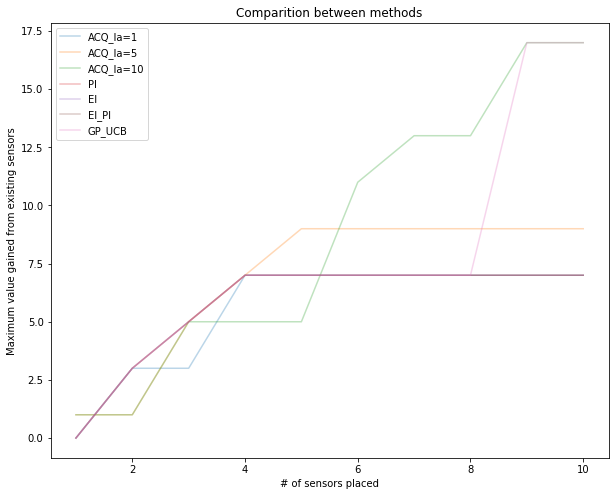

In [55]:
mtns = [mtn_acq1, mtn_acq5, mtn_acq10, mtn_pi, mtn_ei, mtn_ei_pi, mtn_gp_ucb]
names = ['ACQ_la=1', 'ACQ_la=5', 'ACQ_la=10', 'PI', 'EI', 'EI_PI', 'GP_UCB']
xx = range(1, 11)
plt.figure(figsize=(10, 8))
for n, m in zip(names, mtns):
    plt.plot(xx, m, label=n, alpha=0.3)
plt.legend()
plt.xlabel('# of sensors placed')
plt.ylabel('Maximum value gained from existing sensors')
plt.title('Comparition between methods')
plt.show

### 2d problem

Use data from: http://db.csail.mit.edu/labdata/labdata.html

- **Was not able to load the site. Using random synthesized temperature data** 
- **SKlearn GP for 3 dimentions not trivial**

In [6]:
# imports for 3d plots
from mpl_toolkits.mplot3d.axes3d import get_test_data
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [7]:
def f2d(x, y):
    return 2*((x-3)*np.sin(x-3)) + 2 - 0.5*x + np.cos(y+3) + y**(1.2)

In [12]:
# Showing the data
granularity = 20
X = np.linspace(0, 10, granularity)
Y = np.linspace(0, 10, granularity)

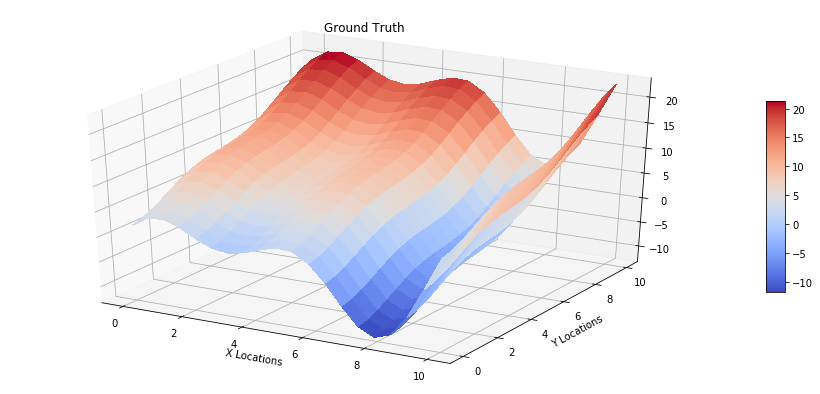

In [13]:
fig = plt.figure(figsize=(16, 7))
ax = fig.add_subplot(1, 1, 1, projection='3d')
XX, YY = np.meshgrid(X, Y)
Z = f2d(XX, YY)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title("Ground Truth")
ax.set_xlabel("X Locations")
ax.set_ylabel("Y Locations")
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

@ TODO below.

Now we have 2D data!

In [31]:
import GPy

rbf = GPy.kern.RBF(input_dim=2, variance=1.0, lengthscale=1.0)
gpr = GPy.models.GPRegression(X_train, Y_train, rbf)

# Fix the noise variance to known value 
gpr.Gaussian_noise.variance = noise**2
gpr.Gaussian_noise.variance.fix()

# Run optimization
gpr.optimize();

# Obtain optimized kernel parameters
l = gpr.rbf.lengthscale.values[0]
sigma_f = np.sqrt(gpr.rbf.variance.values[0])

# Compare with previous results
assert(np.isclose(l_opt, l))
assert(np.isclose(sigma_f_opt, sigma_f))

# Plot the results with the built-in plot function
gpr.plot();

ModuleNotFoundError: No module named 'GPy'

In [ ]:
# https://matplotlib.org/3.1.0/gallery/mplot3d/subplot3d.html

fig = plt.figure(figsize=(18, 6))

#===============
#  First subplot
#===============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo
XX, YY = np.meshgrid(X, Y)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# ax.set_zlim(-1.01, 1.01)
fig.colorbar(surf, shrink=0.5, aspect=10)

#===============
# Second subplot
#===============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')

# plot a 3D wireframe like in the example mplot3d/wire3d_demo
XX, YY, Z = get_test_data(0.05)
ax.plot_wireframe(XX, YY, Z, rstride=10, cstride=10)

plt.show()

In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [2]:
gp = GaussianProcessRegressor()

In [3]:
import numpy as np

In [4]:
X = np.random.randn(10, 2)

In [5]:
X

array([[ 0.76330584, -0.28191336],
       [ 0.25531753,  2.64264153],
       [-0.76659179, -0.6260213 ],
       [ 0.47730574,  0.69767873],
       [-0.25576732,  0.20362141],
       [ 1.10927347,  1.28960385],
       [-1.39793325, -1.06525191],
       [ 0.15540699,  0.17171703],
       [ 2.59062573, -0.44965215],
       [-0.06920621, -0.50808502]])

In [11]:
import matplotlib.pyplot as plt

In [14]:
Z.shape

(20, 20)